# causal inference

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import requests
from bs4 import BeautifulSoup
import time

#import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False

import statsmodels.formula.api as smf
from scipy import stats

## DiD

In [21]:
raw = pd.read_pickle('/Users/som/Documents/github/causal-inference-capstone-project/data/rawdata.pickle')

# 기준 날짜를 datetime.date 형식으로 변환
start_date = datetime.date(2022, 11, 1)

# '서울특별시'와 '부산광역시'에 해당하는 데이터 필터링 후, 필요한 열 선택
df = raw.loc[
    (raw['시도'].map(lambda x: x in ['서울특별시', '부산광역시'])) &
    (raw['일자'] >= start_date),  # 2022-11-01 이후 데이터만 필터링
    ['일자', '시도', '시군구', '목적통행량', 'treated', 'post', 'w']
].copy()
df['일자'] = df['일자'].map(lambda x: datetime.datetime.combine(x, datetime.datetime.min.time()))
df = df.reset_index(drop=True)

df.tail(3)

,일자,시도,시군구,목적통행량,treated,post,w
29927,2024-10-28,서울특별시,중랑구,212689,1,1,1
29928,2024-10-29,서울특별시,중랑구,215401,1,1,1
29929,2024-10-30,서울특별시,중랑구,219057,1,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29930 entries, 0 to 29929
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일자       29930 non-null  datetime64[ns]
 1   시도       29930 non-null  object        
 2   시군구      29930 non-null  object        
 3   목적통행량    29930 non-null  int64         
 4   treated  29930 non-null  int64         
 5   post     29930 non-null  int64         
 6   w        29930 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 1.6+ MB


In [5]:
x = '일자'
y = '목적통행량'

df_did = (df.groupby(["treated", "post"])
            .agg({y:"mean", x: ["min", "max"]}))

df_did['목적통행량'] = df_did['목적통행량'].round(1)
df_did

목적통행량         일자           
                  mean        min        max
treated post                                
0       0     107753.9 2022-11-01 2024-01-26
        1     107157.4 2024-01-27 2024-10-30
1       0     305141.6 2022-11-01 2024-01-26
        1     313286.3 2024-01-27 2024-10-30

In [6]:
y0_est = (df_did.loc[1].loc[0, y] # treated baseline(treat 1 / post 0)
          + df_did.loc[0].diff().loc[1,y]) # control group 추세

att = df_did.loc[1].loc[1, y] - y0_est
att

mean    8741.2
dtype: object

=> ATT = 8741.2 : 정책 도입이 처리 집단의 목적 통행량 증가에 기여했다는 증거로 해석
- 정책 시행 이후, 서울시 각 시군구에서 일별 평균적으로 8741.2건의 목적 통행량 증가가 발생했다

In [15]:
# 고정효과 회귀
df = df.rename(columns={'목적통행량':'y'})

m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit()
# m = smf.ols('y ~ treated:post + C(시도) + C(시군구) + C(일자)', data=df).fit(
#     cov_type='cluster', cov_kwds={'groups': df['시도']})

m.params['treated:post'] # 인과 효과 추정량(시군구, 일 단위)

8741.188502564379

In [16]:
m.conf_int().loc['treated:post'] # 신뢰구간

0     6754.444288
1    10727.932717
Name: treated:post, dtype: float64

# 평행추세가정 검증

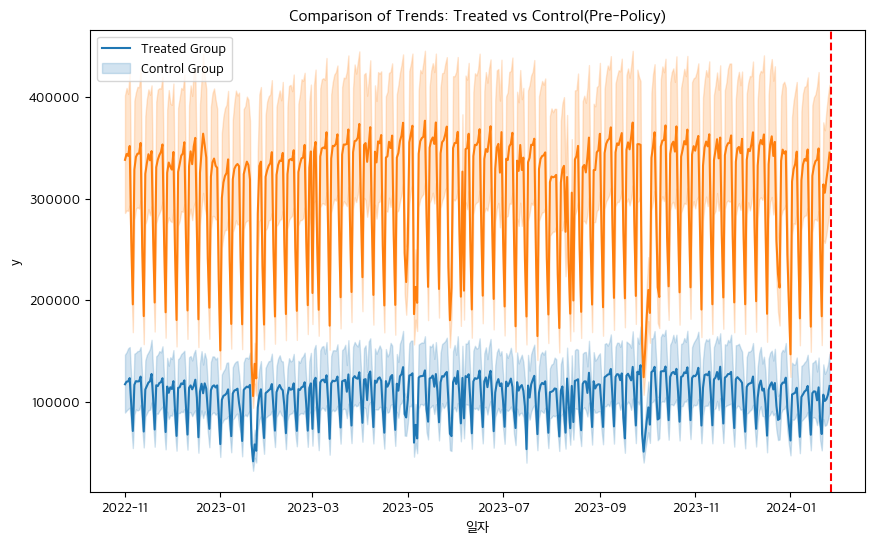

In [17]:
#1)시각적 검증(Pre-treatment기간만)

# 정책 시행 이전 데이터 필터링
pre_data = df[df['post'] == 0]

# 처리 집단과 비처리 집단의 추세 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 정책 도입일자 표기
policy_start_date = pd.to_datetime('2024-01-27') 

plt.figure(figsize=(10, 6))
sns.lineplot(data=pre_data, x='일자', y='y', hue='treated', estimator='mean')
plt.axvline(x=policy_start_date, color='red', linestyle='--', label='Policy Start')
plt.title('Comparison of Trends: Treated vs Control(Pre-Policy)')
plt.legend(['Treated Group', 'Control Group'])
plt.show()

=> 결과: 두 집단이 시간에 따라 동일한 기울기로 증가 또는 감소, 평행추세가정 만족

/var/folders/x6/ym8znrfj3v14qf7twgc36tq80000gn/T/ipykernel_9022/469701118.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='일자', y='y', hue='treated', estimator='mean', ci=None)  # 처리 여부에 따른 추세 그래프


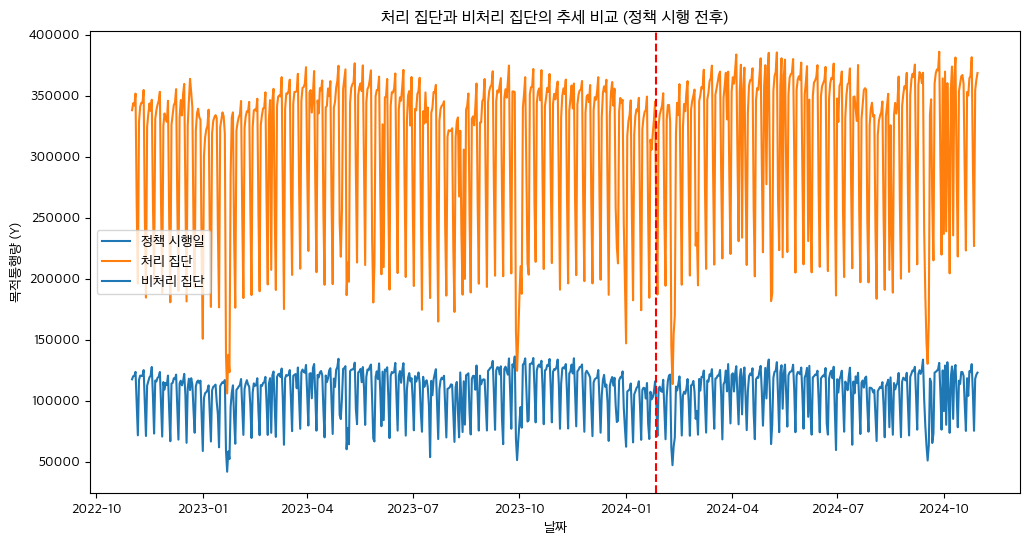

In [18]:
#1)시각적 검증(전체 기간)

# 정책 시행 전후 데이터를 포함한 처리 집단과 비처리 집단의 추세 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='일자', y='y', hue='treated', estimator='mean', ci=None)  # 처리 여부에 따른 추세 그래프

# 정책 시행일을 기준으로 수직선 추가
plt.axvline(x=policy_start_date, color='red', linestyle='--', label='정책 시행일')  # 정책 시행일 기준선

# 제목 및 축 레이블 추가
plt.title('처리 집단과 비처리 집단의 추세 비교 (정책 시행 전후)')
plt.xlabel('날짜')
plt.ylabel('목적통행량 (Y)')
plt.legend(['정책 시행일', '처리 집단', '비처리 집단'])  # 범례 추가
plt.show()

In [20]:
#2) Placebo 테스트

# 정책 시행 이전 데이터를 기반으로 Placebo 분석(임의의 날짜 설정)
placebo_date = pd.to_datetime('2023-11-01')  # 임의의 가상 정책 도입일
pre_data['placebo_post'] = pre_data['일자'] >= placebo_date

# 3. Placebo Test를 위한 DID 회귀모델 생성
model = smf.ols('y ~ treated * placebo_post + C(시도) + C(시군구)', data=pre_data).fit()

# 4. 결과 출력
print(model.summary())

/var/folders/x6/ym8znrfj3v14qf7twgc36tq80000gn/T/ipykernel_9022/1190011943.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_data['placebo_post'] = pre_data['일자'] >= placebo_date


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     2535.
Date:                Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:19:08   Log-Likelihood:            -2.3052e+05
No. Observations:               18532   AIC:                         4.611e+05
Df Residuals:                   18489   BIC:                         4.615e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

=> p-value: 0.099 (유의수준 10%에서는 유의, 5%에서는 유의하지 않음)
- 처리 집단과 비처리 집단 간의 변화가 통계적으로 유의하지 않다고 볼 수 있음.
- 해석: Placebo 정책 시행 이후 두 집단 간의 추세 변화는 유의미하지 않으므로, 평행추세 가정이 대체로 성립한다고 볼 수 있습니다.